In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/My Drive/CS7643_GroupProject')

In [3]:
import pandas as pd
import numpy as np
import csv
import random
from PIL import Image
from collections import defaultdict
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt

from model.ResEmoteNet import ResEmoteNet

%matplotlib inline

#Preprocessing of the fer2013 dataset

Code modified from https://www.kaggle.com/code/vaibhavgovindwar/fer-cnn-lenet-5, https://www.kaggle.com/code/vkoriukina/fer2018-emotion-recognition-pytorch-resnet-18

In [4]:
df = pd.read_csv('/content/drive/My Drive/CS7643_GroupProject/data/fer2013.csv')

In [5]:
df.shape

(35887, 3)

In [6]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
df.Usage.value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


In [8]:
emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=True).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_labels)
emotion_counts

,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Disgust,547


# Seperate Train, Validation, Test Data

In [9]:
train_df = df[df['Usage']=='Training']
val_df   = df[df['Usage']=='PublicTest']
test_df  = df[df['Usage']=='PrivateTest']
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(train_df.shape, val_df.shape, test_df.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


# Create a custom dataset class
Convert pixel strings from csv file to image and label in tensor form

In [10]:
class FER2013Dataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (DataFrame): The dataset loaded using pandas DataFrame.
            transform (callable, optional): Optional transformations to apply to the images.
        """
        self.data = data
        self.transform = transform
        self.labels = data['emotion'].values
        self.pixels = data['pixels'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the pixel string to a numpy array, normalize the pixel by dividing by 255 and reshape to 48x48
        image = (np.array(self.pixels[idx].split(), dtype=np.float32)/255).reshape(48, 48)
        label = int(self.labels[idx])

        # Apply transformations if provided
        if self.transform:
            image = Image.fromarray((image * 255).astype(np.uint8))
            image = self.transform(image)

        # Convert image and label to tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

#Define Transformation and Initialize Datasets

In [11]:
# Train transformation without data augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Normalize pixels to mean=0.5 and std=0.5
])

# Data augmentation of horizontal mirroring, ±10 degree rotations, ±10% image zooms, and ±10% horizontal/vertical shifting,
# Pixel values normalized to [-1, 1]
train_transform_with_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1), # ±10% horizontal and vertical shifting
        scale=(0.9, 1.1) # ±10% zoom (scale between 90% and 110%)
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Normalize pixels to mean=0.5 and std=0.5
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = FER2013Dataset(train_df, train_transform)
train_dataset_with_augmentation = FER2013Dataset(train_df, train_transform_with_augmentation)
val_dataset = FER2013Dataset(val_df, test_transform)
test_dataset = FER2013Dataset(test_df, test_transform)

# Create DataLoader

In [12]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
train_augmented_dataloader = DataLoader(train_dataset_with_augmentation, BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Model = ResEmoteNet

state-of-the-art model for FER2013

https://arxiv.org/abs/2409.10545


In [14]:
model = ResEmoteNet()
model = model.to(device)
print(model)

ResEmoteNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (se): SEBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=256, out_features=16, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=256, bias=False)
      (3): Sigmoid()
    )
  )
  (res_block1): ResidualBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, t

# Define Optimizer, Loss Function and Hyperparameters

In [15]:
EPOCHS = 100
LEARNING_RATE = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=5e-2, lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Define Train, Validation and Accuracy Function

In [16]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    train_running_loss = 0.0
    train_running_acc = 0.0

    for images, labels in tqdm(dataloader, desc="Training...", total=len(dataloader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        train_running_loss += loss.clone().detach()
        train_running_acc += accuracy(outputs.clone().detach(), labels)

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / len(dataloader)
    train_acc = train_running_acc / len(dataloader)

    return train_loss, train_acc

In [17]:
def validate(model, dataloader, optimizer, loss_fn):
    model.eval()

    valid_running_loss = 0.0
    vaild_running_acc = 0.0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating...", total=len(dataloader)):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.clone().detach()
            vaild_running_acc += accuracy(outputs.clone().detach(), labels)

    valid_loss = valid_running_loss / len(dataloader)
    valid_acc = vaild_running_acc / len(dataloader)

    return valid_loss, valid_acc

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Train using augmented data

In [19]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(1, EPOCHS + 1):
    train_epoch_loss, train_epoch_acc = train(model, train_augmented_dataloader, optimizer, loss_function)
    val_epoch_loss, val_epoch_acc = validate(model, val_dataloader, optimizer, loss_function)
    scheduler.step(val_epoch_loss)

    train_loss.append(train_epoch_loss.detach().cpu().numpy())
    val_loss.append(val_epoch_loss.detach().cpu().numpy())
    train_acc.append(train_epoch_acc.detach().cpu().numpy())
    val_acc.append(val_epoch_acc.detach().cpu().numpy())
    print(f'Epoch: {epoch},\
          Train loss: {train_epoch_loss:.4f},\
          Train acc: {train_epoch_acc:.4f},\
          Val loss: {val_epoch_loss:.4f},\
          Val acc: {val_epoch_acc:.4f}\
          ')
print('DONE TRAINING')

Training...:   0%|          | 0/449 [00:00<?, ?it/s]

<ipython-input-10-d62a1405d376>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 1,          Train loss: 1.7839,          Train acc: 0.2635,          Val loss: 1.5902,          Val acc: 0.3770          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 2,          Train loss: 1.6194,          Train acc: 0.3550,          Val loss: 1.4693,          Val acc: 0.4094          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 3,          Train loss: 1.5292,          Train acc: 0.3914,          Val loss: 1.4111,          Val acc: 0.4359          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 4,          Train loss: 1.4736,          Train acc: 0.4153,          Val loss: 1.3850,          Val acc: 0.4442          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 5,          Train loss: 1.4422,          Train acc: 0.4384,          Val loss: 1.3330,          Val acc: 0.4796          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 6,          Train loss: 1.3973,          Train acc: 0.4608,          Val loss: 1.3026,          Val acc: 0.4924          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 7,          Train loss: 1.3654,          Train acc: 0.4776,          Val loss: 1.2410,          Val acc: 0.5084          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 8,          Train loss: 1.3347,          Train acc: 0.4934,          Val loss: 1.2250,          Val acc: 0.5191          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 9,          Train loss: 1.3196,          Train acc: 0.5020,          Val loss: 1.2076,          Val acc: 0.5289          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 10,          Train loss: 1.2969,          Train acc: 0.5082,          Val loss: 1.1756,          Val acc: 0.5558          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 11,          Train loss: 1.2727,          Train acc: 0.5207,          Val loss: 1.1677,          Val acc: 0.5547          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 12,          Train loss: 1.2611,          Train acc: 0.5267,          Val loss: 1.1813,          Val acc: 0.5470          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 13,          Train loss: 1.2485,          Train acc: 0.5304,          Val loss: 1.1392,          Val acc: 0.5654          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 14,          Train loss: 1.2319,          Train acc: 0.5397,          Val loss: 1.1301,          Val acc: 0.5700          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 15,          Train loss: 1.2147,          Train acc: 0.5454,          Val loss: 1.1126,          Val acc: 0.5777          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 16,          Train loss: 1.1995,          Train acc: 0.5555,          Val loss: 1.1090,          Val acc: 0.5728          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 17,          Train loss: 1.1903,          Train acc: 0.5569,          Val loss: 1.0904,          Val acc: 0.5817          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 18,          Train loss: 1.1766,          Train acc: 0.5661,          Val loss: 1.1159,          Val acc: 0.5728          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 19,          Train loss: 1.1718,          Train acc: 0.5670,          Val loss: 1.0985,          Val acc: 0.5826          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 20,          Train loss: 1.1533,          Train acc: 0.5776,          Val loss: 1.0759,          Val acc: 0.5942          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 21,          Train loss: 1.1403,          Train acc: 0.5785,          Val loss: 1.0878,          Val acc: 0.5821          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 22,          Train loss: 1.1342,          Train acc: 0.5840,          Val loss: 1.0684,          Val acc: 0.5952          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 23,          Train loss: 1.1200,          Train acc: 0.5876,          Val loss: 1.0706,          Val acc: 0.5917          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 24,          Train loss: 1.1123,          Train acc: 0.5912,          Val loss: 1.0621,          Val acc: 0.6021          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 25,          Train loss: 1.1078,          Train acc: 0.5923,          Val loss: 1.0668,          Val acc: 0.6068          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 26,          Train loss: 1.0943,          Train acc: 0.6001,          Val loss: 1.0580,          Val acc: 0.6073          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 27,          Train loss: 1.0855,          Train acc: 0.6008,          Val loss: 1.0292,          Val acc: 0.6180          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 28,          Train loss: 1.0812,          Train acc: 0.6063,          Val loss: 1.0197,          Val acc: 0.6189          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 29,          Train loss: 1.0723,          Train acc: 0.6077,          Val loss: 1.0403,          Val acc: 0.6054          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 30,          Train loss: 1.0585,          Train acc: 0.6127,          Val loss: 1.0939,          Val acc: 0.6035          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 31,          Train loss: 1.0588,          Train acc: 0.6149,          Val loss: 1.0557,          Val acc: 0.6142          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 32,          Train loss: 1.0491,          Train acc: 0.6154,          Val loss: 1.0177,          Val acc: 0.6147          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 33,          Train loss: 1.0381,          Train acc: 0.6234,          Val loss: 1.0348,          Val acc: 0.6079          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 34,          Train loss: 1.0373,          Train acc: 0.6194,          Val loss: 1.0069,          Val acc: 0.6202          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 35,          Train loss: 1.0192,          Train acc: 0.6265,          Val loss: 1.0236,          Val acc: 0.6174          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 36,          Train loss: 1.0147,          Train acc: 0.6299,          Val loss: 0.9958,          Val acc: 0.6320          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 37,          Train loss: 1.0121,          Train acc: 0.6320,          Val loss: 0.9741,          Val acc: 0.6295          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 38,          Train loss: 0.9990,          Train acc: 0.6341,          Val loss: 1.0440,          Val acc: 0.6202          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 39,          Train loss: 0.9973,          Train acc: 0.6328,          Val loss: 0.9960,          Val acc: 0.6345          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 40,          Train loss: 0.9886,          Train acc: 0.6404,          Val loss: 0.9888,          Val acc: 0.6416          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 41,          Train loss: 0.9801,          Train acc: 0.6435,          Val loss: 1.0164,          Val acc: 0.6249          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 42,          Train loss: 0.9714,          Train acc: 0.6463,          Val loss: 0.9748,          Val acc: 0.6380          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 43,          Train loss: 0.9578,          Train acc: 0.6520,          Val loss: 1.0069,          Val acc: 0.6293          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 44,          Train loss: 0.9595,          Train acc: 0.6494,          Val loss: 1.0076,          Val acc: 0.6249          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 45,          Train loss: 0.9579,          Train acc: 0.6527,          Val loss: 1.0207,          Val acc: 0.6290          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 46,          Train loss: 0.9494,          Train acc: 0.6575,          Val loss: 0.9920,          Val acc: 0.6309          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 47,          Train loss: 0.9417,          Train acc: 0.6604,          Val loss: 0.9793,          Val acc: 0.6421          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 48,          Train loss: 0.9365,          Train acc: 0.6614,          Val loss: 0.9948,          Val acc: 0.6380          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 49,          Train loss: 0.8570,          Train acc: 0.6884,          Val loss: 0.9801,          Val acc: 0.6449          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 50,          Train loss: 0.8258,          Train acc: 0.7042,          Val loss: 0.9822,          Val acc: 0.6482          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 51,          Train loss: 0.8153,          Train acc: 0.7042,          Val loss: 0.9700,          Val acc: 0.6479          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 52,          Train loss: 0.8065,          Train acc: 0.7101,          Val loss: 0.9838,          Val acc: 0.6476          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 53,          Train loss: 0.7921,          Train acc: 0.7152,          Val loss: 0.9932,          Val acc: 0.6444          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 54,          Train loss: 0.7840,          Train acc: 0.7166,          Val loss: 0.9952,          Val acc: 0.6413          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 55,          Train loss: 0.7785,          Train acc: 0.7171,          Val loss: 0.9751,          Val acc: 0.6529          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 56,          Train loss: 0.7627,          Train acc: 0.7228,          Val loss: 0.9776,          Val acc: 0.6476          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 57,          Train loss: 0.7626,          Train acc: 0.7226,          Val loss: 0.9799,          Val acc: 0.6496          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 58,          Train loss: 0.7526,          Train acc: 0.7280,          Val loss: 0.9831,          Val acc: 0.6534          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 59,          Train loss: 0.7440,          Train acc: 0.7338,          Val loss: 0.9778,          Val acc: 0.6553          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 60,          Train loss: 0.7400,          Train acc: 0.7327,          Val loss: 0.9992,          Val acc: 0.6518          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 61,          Train loss: 0.7400,          Train acc: 0.7331,          Val loss: 0.9810,          Val acc: 0.6542          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 62,          Train loss: 0.7219,          Train acc: 0.7412,          Val loss: 0.9989,          Val acc: 0.6559          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 63,          Train loss: 0.7204,          Train acc: 0.7419,          Val loss: 0.9895,          Val acc: 0.6556          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 64,          Train loss: 0.7209,          Train acc: 0.7410,          Val loss: 0.9907,          Val acc: 0.6600          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 65,          Train loss: 0.7176,          Train acc: 0.7436,          Val loss: 0.9941,          Val acc: 0.6553          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 66,          Train loss: 0.7154,          Train acc: 0.7433,          Val loss: 0.9955,          Val acc: 0.6561          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 67,          Train loss: 0.7122,          Train acc: 0.7431,          Val loss: 0.9918,          Val acc: 0.6559          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 68,          Train loss: 0.7069,          Train acc: 0.7458,          Val loss: 1.0037,          Val acc: 0.6556          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 69,          Train loss: 0.7101,          Train acc: 0.7454,          Val loss: 0.9884,          Val acc: 0.6550          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 70,          Train loss: 0.7103,          Train acc: 0.7451,          Val loss: 0.9974,          Val acc: 0.6570          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 71,          Train loss: 0.7071,          Train acc: 0.7468,          Val loss: 0.9906,          Val acc: 0.6534          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 72,          Train loss: 0.7126,          Train acc: 0.7466,          Val loss: 0.9867,          Val acc: 0.6545          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 73,          Train loss: 0.7093,          Train acc: 0.7480,          Val loss: 0.9952,          Val acc: 0.6537          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 74,          Train loss: 0.7021,          Train acc: 0.7466,          Val loss: 0.9955,          Val acc: 0.6553          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 75,          Train loss: 0.7059,          Train acc: 0.7441,          Val loss: 0.9938,          Val acc: 0.6539          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 76,          Train loss: 0.7046,          Train acc: 0.7462,          Val loss: 0.9914,          Val acc: 0.6570          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 77,          Train loss: 0.7050,          Train acc: 0.7476,          Val loss: 0.9990,          Val acc: 0.6561          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 78,          Train loss: 0.6995,          Train acc: 0.7475,          Val loss: 0.9921,          Val acc: 0.6550          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 79,          Train loss: 0.7087,          Train acc: 0.7459,          Val loss: 0.9872,          Val acc: 0.6550          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 80,          Train loss: 0.7068,          Train acc: 0.7459,          Val loss: 0.9984,          Val acc: 0.6548          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 81,          Train loss: 0.7005,          Train acc: 0.7463,          Val loss: 0.9952,          Val acc: 0.6542          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 82,          Train loss: 0.7059,          Train acc: 0.7457,          Val loss: 0.9878,          Val acc: 0.6570          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 83,          Train loss: 0.7062,          Train acc: 0.7488,          Val loss: 0.9888,          Val acc: 0.6561          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 84,          Train loss: 0.7051,          Train acc: 0.7465,          Val loss: 0.9918,          Val acc: 0.6550          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 85,          Train loss: 0.7034,          Train acc: 0.7476,          Val loss: 0.9871,          Val acc: 0.6561          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 86,          Train loss: 0.7039,          Train acc: 0.7456,          Val loss: 0.9909,          Val acc: 0.6556          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 87,          Train loss: 0.7038,          Train acc: 0.7457,          Val loss: 0.9818,          Val acc: 0.6523          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 88,          Train loss: 0.7043,          Train acc: 0.7479,          Val loss: 0.9942,          Val acc: 0.6539          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 89,          Train loss: 0.7087,          Train acc: 0.7464,          Val loss: 0.9894,          Val acc: 0.6550          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 90,          Train loss: 0.7048,          Train acc: 0.7463,          Val loss: 0.9904,          Val acc: 0.6553          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 91,          Train loss: 0.7042,          Train acc: 0.7460,          Val loss: 0.9871,          Val acc: 0.6550          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 92,          Train loss: 0.7055,          Train acc: 0.7449,          Val loss: 0.9940,          Val acc: 0.6548          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 93,          Train loss: 0.7040,          Train acc: 0.7444,          Val loss: 0.9945,          Val acc: 0.6537          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 94,          Train loss: 0.7080,          Train acc: 0.7473,          Val loss: 0.9934,          Val acc: 0.6561          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 95,          Train loss: 0.7058,          Train acc: 0.7438,          Val loss: 0.9899,          Val acc: 0.6537          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 96,          Train loss: 0.7110,          Train acc: 0.7434,          Val loss: 0.9910,          Val acc: 0.6550          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 97,          Train loss: 0.7014,          Train acc: 0.7472,          Val loss: 0.9893,          Val acc: 0.6567          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 98,          Train loss: 0.7105,          Train acc: 0.7446,          Val loss: 0.9949,          Val acc: 0.6556          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 99,          Train loss: 0.7009,          Train acc: 0.7484,          Val loss: 0.9893,          Val acc: 0.6548          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 100,          Train loss: 0.6991,          Train acc: 0.7514,          Val loss: 0.9911,          Val acc: 0.6534          
DONE TRAINING


# Loss and Accuracy Plot For Train and Validation Data

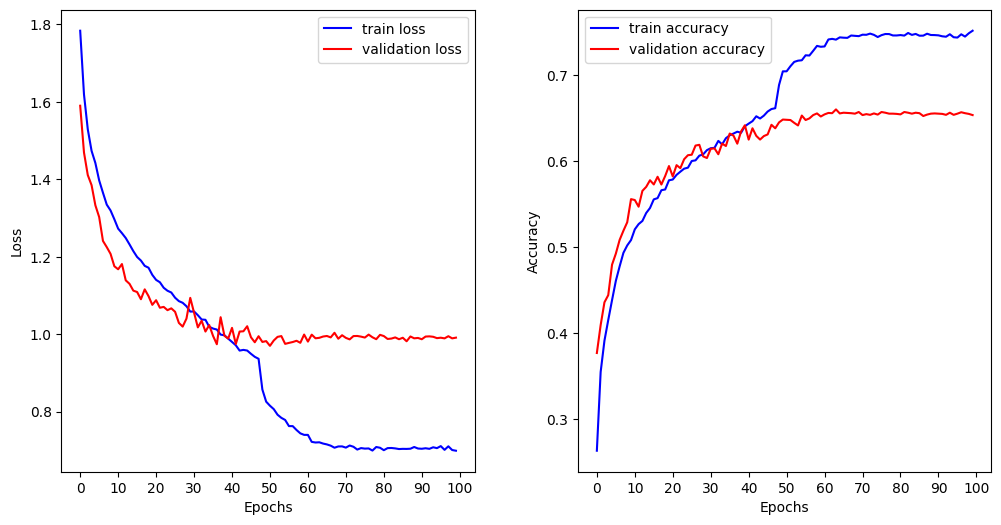

In [20]:
plt.figure(figsize=(12, 6))

# loss plot
plt.subplot(121)
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, EPOCHS + 1, 10))
#plt.xticks(range(EPOCHS), range(1, EPOCHS + 1))
plt.ylabel('Loss')
plt.legend()


# accuracy plot
plt.subplot(122)
plt.plot(train_acc, color='blue', label='train accuracy')
plt.plot(val_acc, color='red', label='validation accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, EPOCHS + 1, 10))
#plt.xticks(range(EPOCHS), range(1, EPOCHS + 1))
plt.ylabel('Accuracy')
plt.legend()
plt.subplots_adjust(wspace=0.25)
plt.show()

# Define Test Function

In [21]:
classes = list(emotion_labels.values())
def test(model, dataloader):
    model.eval()

    # prepare to count predictions for each class
    correct_pred = defaultdict(int)
    total_pred = defaultdict(int)

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing...", total=len(dataloader)):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            all_labels.extend(labels)
            all_predictions.extend(predictions)

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    return correct_pred, total_pred, all_labels, all_predictions

correct_pred, total_pred, all_labels, all_predictions = test(model, test_dataloader)

Testing...:   0%|          | 0/57 [00:00<?, ?it/s]

<ipython-input-10-d62a1405d376>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


# Test Accuracy for Each Class

In [22]:
for classname, correct_count in dict(sorted(correct_pred.items())).items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.4f}')

total_acc = sum(correct_pred[class_name] for class_name in classes) / len(test_dataset)
print(f"Total test accuracy: {total_acc:.4f}")

Accuracy for class: Angry is 0.6232
Accuracy for class: Disgust is 0.6182
Accuracy for class: Fear  is 0.4034
Accuracy for class: Happy is 0.8953
Accuracy for class: Neutral is 0.7077
Accuracy for class: Sad   is 0.5455
Accuracy for class: Surprise is 0.8053
Total test accuracy: 0.6804


# Confusion Matrix

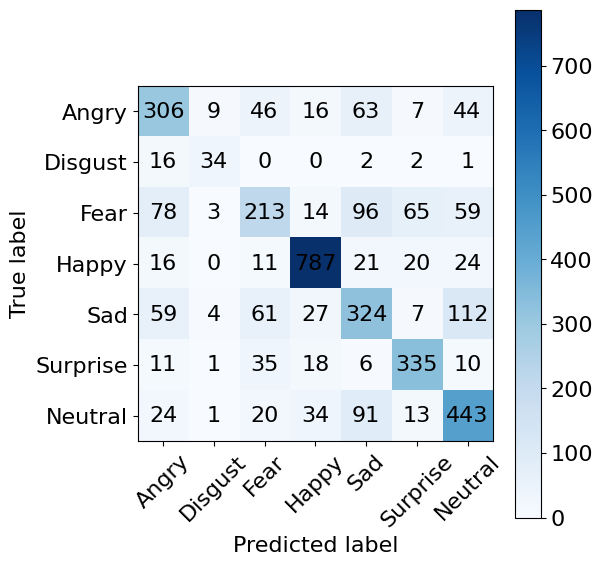

In [23]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix)
    for i in range(0, len(classes)):
        for j in range(0, len(classes)):
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(classes))
    ax.set_xticks(ticks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(all_labels, all_predictions)
plt.show()